In [122]:
import numpy as np
import xarray as xr
import xesmf as xe
import glob 

# find all files
tas_files = np.sort(glob.glob('/home/disk/pna2/aodhan/CESM2_LENS/monthly_TAS/*HIST*.nc'))
psl_files = np.sort(glob.glob('/home/disk/pna2/aodhan/CESM2_LENS/monthly_PSL/*.nc'))

# remove timeframe
tas_files_no_years = [i[:-16] for i in tas_files]
psl_files_no_years = [i[:-16] for i in psl_files]

# find all files which share same base string, i.e., come from same ensemble member etc...
uniqueTASfiles = np.sort(np.unique(tas_files_no_years))
uniquePSLfiles = np.sort(np.unique(psl_files_no_years))

# for each of these sets of files, find all members in set and combine them
combined_xarrays = []
for x in range(0, len(uniqueTASfiles)):
    TASHistSspString = uniqueTASfiles[x].split('.')
    TASHistSspString[2] = '*'
    TASBaseString = ".".join(TASHistSspString)
    PSLHistSspString = uniquePSLfiles[x].split('.')
    PSLHistSspString[2] = '*'
    PSLBaseString = ".".join(PSLHistSspString)
    members_of_TASset = np.sort(glob.glob(TASBaseString + '*'))
    members_of_PSLset = np.sort(glob.glob(PSLBaseString + '*'))
    if len(members_of_TASset) == len(members_of_PSLset):
        # for all netCDF files in a given set, load them and combine them into one spliced xarray
        TAS_xr = [xr.open_dataset(xr_file) for xr_file in members_of_TASset]
        PSL_xr = [xr.open_dataset(xr_file) for xr_file in members_of_PSLset]
        TAScombined = xr.concat(objs=TAS_xr, dim='time')
        TAScombined = TAScombined[['time', 'lat', 'lon', 'TREFHT']]
        PSLcombined = xr.concat(objs=PSL_xr, dim='time')
        PSLcombined = PSLcombined[['time', 'lat', 'lon', 'PSL']]

        # set up regridder, note that TAS and PSL have same shape
        latitudes = TAScombined.lat.values
        longitudes = TAScombined.lon.values
        InputGrid = {"lon": longitudes, "lat": latitudes}
        OutputGrid = {"lon": np.arange(1.25, 358.751, 2.5), "lat": np.arange(-88.75, 88.751, 2.5)}
        regridder = xe.Regridder(InputGrid, OutputGrid, "bilinear", periodic=True)

        # regrid the TAS and PSL data
        TAS_2p5x2p5 = regridder(TAScombined)
        PSL_2p5x2p5 = regridder(PSLcombined)

        # combine the regridded TAS and PSL data
        combined_xr = xr.combine_by_coords(data_objects=[TAS_2p5x2p5, PSL_2p5x2p5])

        # Get some of the metadata that may be useful for a file name 
        file_name = TAScombined.case.split('.')
        file_name = file_name[4:]
        xarray_name = "_".join(file_name)

        # save this reprocessed file
        base_path = '/home/disk/pna2/aodhan/CESM2_LENS/MonthlyReprocessedCombinedTASandPSL/'
        new_file_path = base_path + xarray_name + '.nc'
        combined_xr.to_netcdf(path=new_file_path, mode='w')
        print('Saved: ', xarray_name)
    else:
        print('Incompatible sizes for files from set: ', members_of_TASset[0])
    

Saved:  LE2-1001_001
Saved:  LE2-1021_002
Saved:  LE2-1041_003
Saved:  LE2-1061_004
Saved:  LE2-1081_005
Saved:  LE2-1101_006
Saved:  LE2-1121_007
Saved:  LE2-1141_008
Saved:  LE2-1161_009
Saved:  LE2-1181_010
Saved:  LE2-1231_001
Saved:  LE2-1231_002
Saved:  LE2-1231_003
Saved:  LE2-1231_004
Saved:  LE2-1231_005
Saved:  LE2-1231_006
Saved:  LE2-1231_007
Saved:  LE2-1231_008
Saved:  LE2-1231_009
Saved:  LE2-1231_010
Saved:  LE2-1251_001
Saved:  LE2-1251_002
Saved:  LE2-1251_003
Saved:  LE2-1251_004
Saved:  LE2-1251_005
Saved:  LE2-1251_006
Saved:  LE2-1251_007
Saved:  LE2-1251_008
Saved:  LE2-1251_009
Saved:  LE2-1251_010
Saved:  LE2-1281_001
Saved:  LE2-1281_002
Saved:  LE2-1281_003
Saved:  LE2-1281_004
Saved:  LE2-1281_005
Saved:  LE2-1281_006
Saved:  LE2-1281_007
Saved:  LE2-1281_008
Saved:  LE2-1281_009
Saved:  LE2-1281_010
Saved:  LE2-1301_001
Saved:  LE2-1301_002
Saved:  LE2-1301_003
Saved:  LE2-1301_004
Saved:  LE2-1301_005
Saved:  LE2-1301_006
Saved:  LE2-1301_007
Saved:  LE2-1

# Save a version of the NDJFM data with the arctic temperature timeseries

<xarray.Dataset>
Dimensions:  (time: 2064, lat: 72, lon: 144)
Coordinates:
  * time     (time) object 1851-01-01 00:00:00 ... 2022-12-01 00:00:00
  * lat      (lat) float64 -88.75 -86.25 -83.75 -81.25 ... 83.75 86.25 88.75
  * lon      (lon) float64 1.25 3.75 6.25 8.75 11.25 ... 351.2 353.8 356.2 358.8
Data variables:
    PSL      (time, lat, lon) float32 ...
    TREFHT   (time, lat, lon) float32 ...
Attributes:
    regrid_method:  bilinear


In [85]:
from sklearn.linear_model import LinearRegression

# Step one: Dynamically adjust TAS 
slp_weights = np.cos(np.deg2rad(lats[44:]))
X = forced_PSL_fields_stdzd_nh.copy()
Y = forced_TAS_timeseries_stdzd.copy()
Zs_tas = []
for k in range(3):
    X, Y, Z = dynamic_adjustment(X, Y, weights=slp_weights, pls_number=k)
    Zs_tas.append(Z)
tas_reg = LinearRegression().fit(np.transpose(Zs_tas), forced_TAS_timeseries_MeanRemoved)
tas_dynamically_induced = tas_reg.predict(np.transpose(Zs_tas))


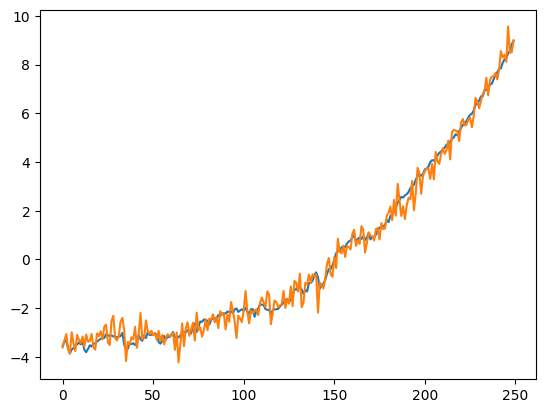

In [86]:
plt.plot(forced_TAS_timeseries_MeanRemoved)
plt.plot(tas_dynamically_induced)

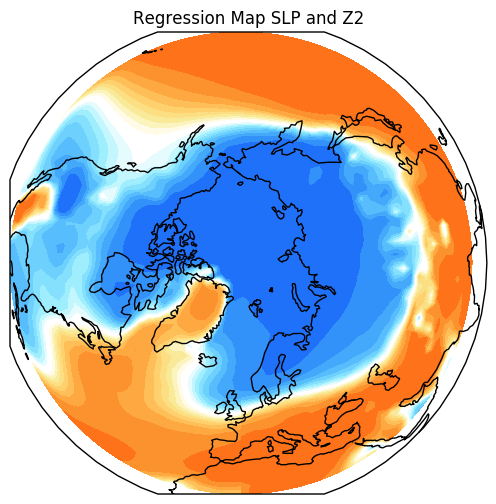

In [78]:
import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point
from matplotlib.colors import LinearSegmentedColormap

def regression_maps(slp_djf_std, z_ts):
    # detrend SLP
    slp_detrended = []
    for lat in range(np.shape(slp_djf_std)[1]):
        lat_line = []
        for lon in range(np.shape(slp_djf_std)[2]):
            slp_djf_std_ts = slp_djf_std[:,lat,lon]
            slp_djf_std_regression = stats.pearsonr(slp_djf_std_ts, z_ts)[0]
            #X_regression = slp_djf_std_regression[1] + slp_djf_std_regression[0]*decades
            #X_detrended_ts = slp_djf_std_ts - X_regression
            #Z_slp_regression = stats.linregress(x=z_ts, y=X_detrended_ts)[0]
            lat_line.append(slp_djf_std_regression)
        slp_detrended.append(lat_line)
    return(slp_detrended)

# find correlation maps of detrended SLP with PLS regression components
regression_maps_with_Zs = []
for z in Zs_tas:
    regression_map_NH = regression_maps(forced_PSL_fields_stdzd_nh, z)
    regression_maps_with_Zs.append(regression_map_NH)
regression_maps_with_Zs = np.array(regression_maps_with_Zs)

# Create Custom Color Map
colors = np.array([(22,98,248), (48,141,250), (71,172,251), (100,201,252), (129,222,253),(162,240,254), (215,249,253), (255,255,255), 
                   (255,255,255), (255,249,217), (247,236,155), (254,221,128), (254,202,100), (255,173,71), (252,142,42), (255,101,15)])/255
custom_cmap = LinearSegmentedColormap.from_list('cmap', colors)

#Plotting is below
lat_bins = np.linspace(20, 90., 28)
lon_bins = np.linspace(0, 360, 144)

lim = np.linspace(-1, 1, 21)
subplot_kw = dict(projection=ccrs.Orthographic(central_longitude=0, central_latitude=90))
fig, ax = plt.subplots(1, 1, figsize=(7, 6), subplot_kw=subplot_kw)
####################################################################################
ax.coastlines()
#ax.set_extent([ -20.0, 90.0])
ax.set_title('Regression Map SLP and Z2')
map_cyclic, lon = add_cyclic_point(regression_maps_with_Zs[0], coord=lon_bins)
im = ax.contourf(lon, lat_bins, map_cyclic, 20, levels=lim,
                 transform=ccrs.PlateCarree(), extend='both', cmap=custom_cmap)

In [8]:
import netCDF4 as nc

# Create the NetCDF file
filename = '/home/disk/pna2/aodhan/CESM2_LENS/NDJFM_TASandPSL_Maps.nc'
dataset = nc.Dataset(filename, 'w', format='NETCDF4')

# Define the dimensions
dataset.createDimension('ensemble_member', 100)
dataset.createDimension('period', 40)
dataset.createDimension('time', 44)
dataset.createDimension('lat', 72)
dataset.createDimension('lon', 144)

# Define the variables
var1 = dataset.createVariable('TAS', np.float32, ('ensemble_member', 'period', 'time', 'lat', 'lon'))
var2 = dataset.createVariable('PSL', np.float32, ('ensemble_member', 'period', 'time', 'lat', 'lon'))
var3 = dataset.createVariable('ArcticTAS', np.float32, ('ensemble_member', 'period', 'time'))

# Assign the values
# Assuming arr1, arr2, and arr3 are the three numpy arrays
var1[:] = TAS_fields
var2[:] = PSL_fields
var3[:] = TAS_arctic_timeseries

# Close the NetCDF file
dataset.close()

# Open the NetCDF file in append mode
filename = '/home/disk/pna2/aodhan/CESM2_LENS/NDJFM_TASandPSL_Maps.nc'
dataset = nc.Dataset(filename, 'a')

# Add coordinate values for the dimension 'ensemble_member'
ens_var = dataset.createVariable('ensemble_member', 'f8', ('ensemble_member',))
ens_values = np.arange(1, 101)
ens_var[:] = ens_values

# Add coordinate values for the dimension 'period'
period_var = dataset.createVariable('period', 'f8', ('period',))
period_values = np.arange(1859, 2055, 5)
period_var[:] = period_values

# Add coordinate values for the dimension 'time'
time_var = dataset.createVariable('time', 'f8', ('time',))
time_values = np.arange(1, 45)
time_var[:] = time_values

# Add coordinate values for the dimension 'lat'
lat_var = dataset.createVariable('lat', 'f8', ('lat',))
lat_values = lats
lat_var[:] = lat_values

# Add coordinate values for the dimension 'lon'
lon_var = dataset.createVariable('lon', 'f8', ('lon',))
lon_values = lons
lon_var[:] = lon_values

# Close the NetCDF file
dataset.close()